In [50]:
# src/plot_spatiotemporal.py

import os
import numpy as np
import matplotlib.pyplot as plt

def getFirstArrivals(density, threshold):
    """
    Finds the first time index where the density exceeds a given threshold
    for each spatial site.
    
    Parameters:
        density (2D array): Density matrix of shape (time, site).
        threshold (float): Minimum value considered a significant 'arrival'.

    Returns:
        arrivals (list of tuples): List of (site, time) tuples marking the first 
                                   time a signal arrives at each site.
    """
    num_times, num_sites = density.shape
    arrivals = []

    for site in range(num_sites):
        for time in range(num_times):
            if density[time, site] > threshold:
                arrivals.append((site, time))
                break  # Only take the first instance
    return arrivals


# === Load simulation data ===

# Define path to the data file
data_pathA = os.path.join("src", "N50B0LFIMHeffb2lc60frhoA.txt")
data_pathNA = os.path.join("src", "N50B0LFIMHeffb2lc60frhoNA.txt")

# Load data from file; first column = time, rest = spatial density over time
raw_dataA = np.loadtxt(data_pathA)
raw_dataNA = np.loadtxt(data_pathNA)

# Separate time axis and density matrix
times = raw_dataA[:, 0]  # Assuming time columns are identical

frhoa=raw_dataA
frhona=raw_dataNA

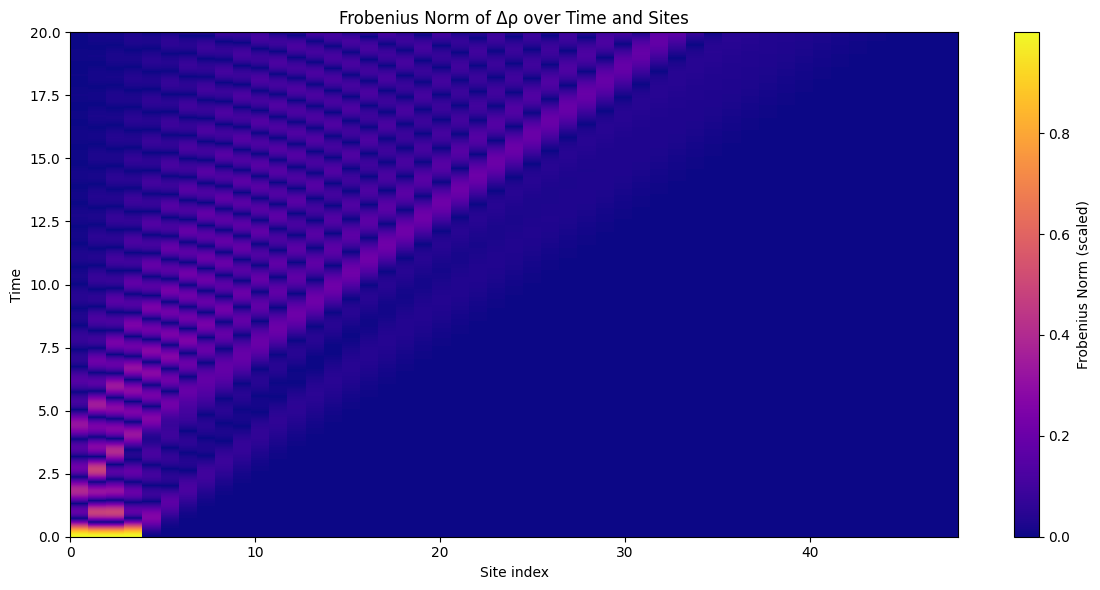

In [51]:
import numpy as np
import matplotlib.pyplot as plt

# Assumptions — set appropriately
ns = 49                        # Number of spatial sites
tmax = times[-1]               # Maximum time
tInterval = times[1] - times[0]  # Time step (assuming uniform spacing)
n_times = len(times)           # Number of time steps

# Construct 2x2 density matrices for rhona and rhoa
rhona = []
rhoa = []

for dt in range(n_times):
    rhona_t = []
    rhoa_t = []
    for siteindex in range(ns):
        # Extract matrix elements from frhona
        p = frhona[dt, 2 + 3 * siteindex]
        re = frhona[dt, 3 + 3 * siteindex]
        im = frhona[dt, 4 + 3 * siteindex]
        rhona_site = np.array([
            [p, re + 1j * im],
            [re - 1j * im, 1 - p]
        ])
        rhona_t.append(rhona_site)

        # Extract matrix elements from frhoa
        p_a = frhoa[dt, 2 + 3 * siteindex]
        re_a = frhoa[dt, 3 + 3 * siteindex]
        im_a = frhoa[dt, 4 + 3 * siteindex]
        rhoa_site = np.array([
            [p_a, re_a + 1j * im_a],
            [re_a - 1j * im_a, 1 - p_a]
        ])
        rhoa_t.append(rhoa_site)

    rhona.append(rhona_t)
    rhoa.append(rhoa_t)

# Convert lists to numpy arrays: shape (n_times, ns, 2, 2)
rhona = np.array(rhona)
rhoa = np.array(rhoa)

# Reverse time axis to align with Mathematica convention
rhona = rhona[::-1]
rhoa = rhoa[::-1]

# Compute the difference Δρ = rhona - rhoa
rhoDelta = rhona - rhoa

# Compute Δρ† Δρ for each time and site
rhorhodaggerDelta = np.matmul(np.conj(np.transpose(rhoDelta, (0, 1, 3, 2))), rhoDelta)

# Calculate Frobenius norm = sqrt(Tr(Δρ† Δρ)) * 100 * sqrt(2)
FrobeniusNorm = np.sqrt(np.real(np.trace(rhorhodaggerDelta, axis1=2, axis2=3))) * 100 * np.sqrt(2)
FrobeniusNorm=FrobeniusNorm[::-1]

# Shape: (n_times, ns)

# === Plotting ===

plt.figure(figsize=(12, 6))
im = plt.imshow(FrobeniusNorm, aspect='auto', origin='lower',
                extent=[0, ns-1, 0, tmax],
                cmap='plasma', interpolation='none')

plt.colorbar(im, label='Frobenius Norm (scaled)')
plt.xlabel('Site index')
plt.ylabel('Time')
plt.title('Frobenius Norm of Δρ over Time and Sites')
plt.tight_layout()
plt.show()


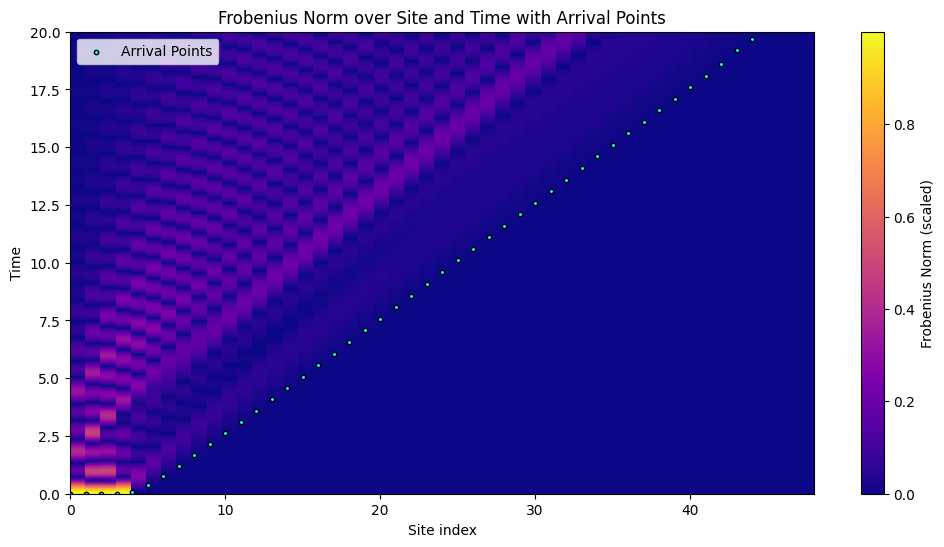

In [56]:
threshold = 0.004  # Adjust as needed

arrival_times = []
site_indices = np.arange(FrobeniusNorm.shape[1])

for site in site_indices:
    norm_vs_time = FrobeniusNorm[:, site]
    
    # Find indices where Frobenius norm crosses threshold
    above_thresh = np.where(norm_vs_time > threshold)[0]
    
    if len(above_thresh) > 0:
        # Take the first crossing index as arrival time
        arrival_idx = above_thresh[0]
        arrival_times.append(times[arrival_idx])
    else:
        # No arrival detected; keep NaN to mark missing arrival
        arrival_times.append(np.nan)

arrival_times = np.array(arrival_times)
# === Plotting the results ===
plt.figure(figsize=(12, 6))
im = plt.imshow(FrobeniusNorm, aspect='auto', origin='lower',
                extent=[0, FrobeniusNorm.shape[1]-1, times[0], times[-1]],
                cmap='plasma', interpolation='none')
plt.colorbar(im, label='Frobenius Norm (scaled)')
plt.xlabel('Site index')
plt.ylabel('Time')

# Plot arrival points (exclude NaNs)
valid_arrivals = ~np.isnan(arrival_times)
plt.scatter(site_indices[valid_arrivals], arrival_times[valid_arrivals],
            color='cyan', label='Arrival Points', s=10, edgecolors='k')

plt.legend()
plt.title('Frobenius Norm over Site and Time with Arrival Points')
plt.show()


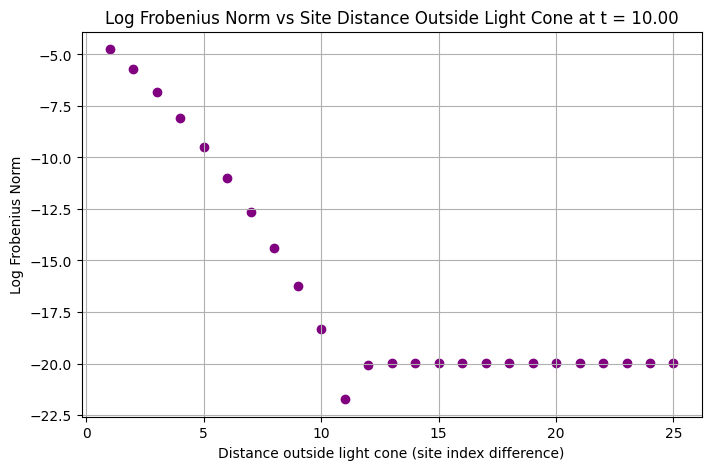

In [53]:
import numpy as np
import matplotlib.pyplot as plt

# Choose your time slice (time value and index)
t_slice_val = 10.0
t_slice_idx = np.argmin(np.abs(times - t_slice_val))

# Frobenius norm at this time slice
fn_slice = FrobeniusNorm[t_slice_idx, :]

# Find the arrival site for this time slice:
# Which site has arrival_time just <= t_slice_val?
valid_sites = np.where(arrival_times <= times[t_slice_idx])[0]
if len(valid_sites) == 0:
    print("No arrival sites before this time slice")
    arrival_site_at_t = 0
else:
    arrival_site_at_t = valid_sites.max()

# Compute distance outside light cone (site index difference)
site_indices = np.arange(ns)
distance = site_indices - arrival_site_at_t

# Select sites outside the light cone (distance > 0)
valid = distance > 0
dist_valid = distance[valid]
fn_valid = fn_slice[valid]

# Log of Frobenius norm, add epsilon to avoid log(0)
log_fn = np.log(fn_valid + 1e-12)

# Plot
plt.figure(figsize=(8, 5))
plt.scatter(dist_valid, log_fn, color='purple')
plt.xlabel('Distance outside light cone (site index difference)')
plt.ylabel('Log Frobenius Norm')
plt.title(f'Log Frobenius Norm vs Site Distance Outside Light Cone at t = {times[t_slice_idx]:.2f}')
plt.grid(True)
plt.show()


Fitted parameters: a = 3.2731, n = 0.7042


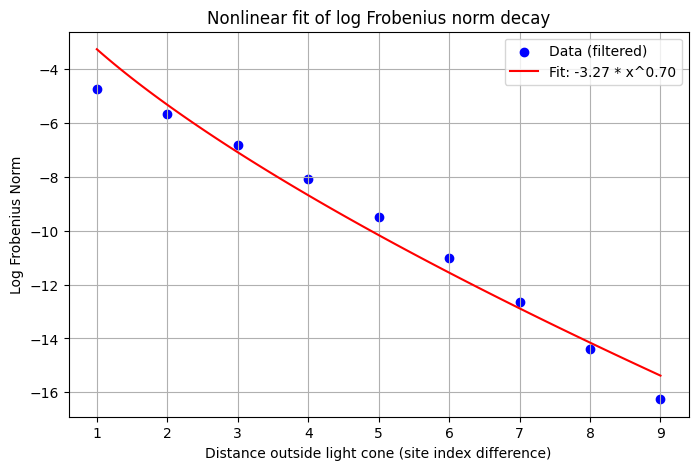

In [55]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Your filtered data arrays: x_fit_data, y_fit_data (log Frobenius norm)
# Ensure y_fit_data < 0 because y = -a x^n < 0 by model

def model_func(x, a, n):
    return -a * x**n

# Initial guess close to expected values
p0 = [1.0, 1.5]

# Fit to data
params, covariance = curve_fit(model_func, x_fit_data, y_fit_data, p0=p0)

a_fit, n_fit = params
print(f"Fitted parameters: a = {a_fit:.4f}, n = {n_fit:.4f}")

# Plotting fit
x_line = np.linspace(min(x_fit_data), max(x_fit_data), 100)
y_line = model_func(x_line, a_fit, n_fit)

plt.figure(figsize=(8, 5))
plt.scatter(x_fit_data, y_fit_data, label='Data (filtered)', color='blue')
plt.plot(x_line, y_line, 'r-', label=f'Fit: -{a_fit:.2f} * x^{n_fit:.2f}')
plt.xlabel('Distance outside light cone (site index difference)')
plt.ylabel('Log Frobenius Norm')
plt.title('Nonlinear fit of log Frobenius norm decay')
plt.legend()
plt.grid(True)
plt.show()
